Using device: cuda
Files already downloaded and verified
Starting Training...
Epoch [1/40] - Gen Loss: 2.4516, Disc Loss: 0.9130
Epoch [2/40] - Gen Loss: 5.9756, Disc Loss: 0.7755
Epoch [3/40] - Gen Loss: 2.8076, Disc Loss: 0.7956
Epoch [4/40] - Gen Loss: 3.6678, Disc Loss: 0.7152
Epoch [5/40] - Gen Loss: 1.4960, Disc Loss: 0.6936
Epoch [6/40] - Gen Loss: 3.9324, Disc Loss: 0.7089
Epoch [7/40] - Gen Loss: 3.0282, Disc Loss: 0.4030
Epoch [8/40] - Gen Loss: 2.8383, Disc Loss: 0.8586
Epoch [9/40] - Gen Loss: 3.2130, Disc Loss: 0.5781
Epoch [10/40] - Gen Loss: 2.7310, Disc Loss: 0.3936
Epoch [11/40] - Gen Loss: 3.6359, Disc Loss: 0.6628
Epoch [12/40] - Gen Loss: 2.9055, Disc Loss: 0.7247
Epoch [13/40] - Gen Loss: 3.8271, Disc Loss: 0.5088
Epoch [14/40] - Gen Loss: 7.8100, Disc Loss: 0.3511
Epoch [15/40] - Gen Loss: 0.8183, Disc Loss: 0.6291
Epoch [16/40] - Gen Loss: 3.9145, Disc Loss: 0.4246
Epoch [17/40] - Gen Loss: 2.8299, Disc Loss: 0.3859
Epoch [18/40] - Gen Loss: 3.3051, Disc Loss: 0.

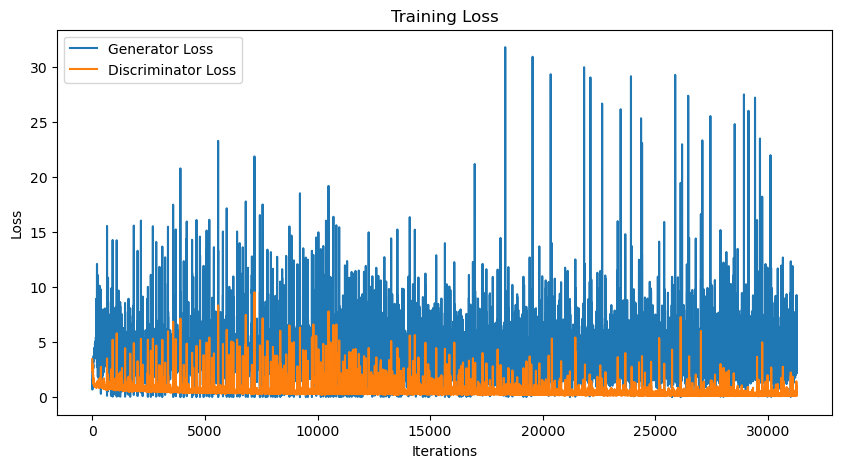

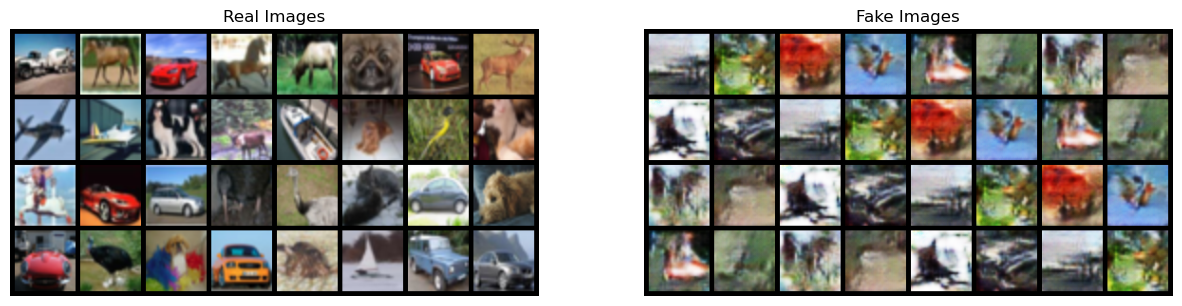

In [1]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models import inception_v3
from scipy.linalg import sqrtm

# Directories for results
os.makedirs("Results/ACGAN_FAKE", exist_ok=True)
os.makedirs("Results/ACGAN_REAL", exist_ok=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
NOISE_DIM = 100
NUM_CLASSES = 10
EMBED_SIZE = 100
NUM_EPOCHS = 40

# Dataset and Dataloader
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3),
])
dataset = CIFAR10(root="./CIFAR10", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(NUM_CLASSES, EMBED_SIZE)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(NOISE_DIM + EMBED_SIZE, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        embed = self.embed(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat([noise, embed], dim=1)
        return self.model(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        self.validity = nn.Conv2d(512, 1, 4, 1, 0)
        self.label = nn.Conv2d(512, NUM_CLASSES, 4, 1, 0)

    def forward(self, x):
        features = self.disc(x)
        validity = self.validity(features).view(-1)
        label = self.label(features).view(-1, NUM_CLASSES)
        return validity, label

# Initialize models and optimizers
gen = Generator().to(device)
disc = Discriminator().to(device)
gen.apply(lambda m: nn.init.normal_(m.weight, 0.0, 0.02) if isinstance(m, nn.Conv2d) else None)
disc.apply(lambda m: nn.init.normal_(m.weight, 0.0, 0.02) if isinstance(m, nn.Conv2d) else None)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
auxiliary_loss = nn.CrossEntropyLoss()

# Training
print("Starting Training...")
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1, device=device)
FID_list, GenLoss, DiscLoss = [], [], []

for epoch in range(NUM_EPOCHS):
    for real_images, labels in dataloader:
        real_images, labels = real_images.to(device), labels.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        noise = torch.randn(batch_size, NOISE_DIM, 1, 1, device=device)
        fake_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
        fake_images = gen(noise, fake_labels)

        real_validity, real_aux = disc(real_images)
        fake_validity, fake_aux = disc(fake_images.detach())

        real_loss = adversarial_loss(real_validity, torch.ones_like(real_validity)) + auxiliary_loss(real_aux, labels)
        fake_loss = adversarial_loss(fake_validity, torch.zeros_like(fake_validity)) + auxiliary_loss(fake_aux, fake_labels)
        disc_loss = (real_loss + fake_loss) / 2

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator
        gen_validity, gen_aux = disc(fake_images)
        gen_loss = adversarial_loss(gen_validity, torch.ones_like(gen_validity)) + auxiliary_loss(gen_aux, fake_labels)

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        # Log losses
        GenLoss.append(gen_loss.item())
        DiscLoss.append(disc_loss.item())

    # Generate and save images
    with torch.no_grad():
        fake_images = gen(fixed_noise, torch.arange(32, device=device) % NUM_CLASSES)
        utils.save_image(fake_images, f"Results/ACGAN_FAKE/epoch_{epoch + 1:03d}.png", normalize=True)

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] - Gen Loss: {gen_loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}")

# Plot and save loss curves
plt.figure(figsize=(10, 5))
plt.plot(GenLoss, label="Generator Loss")
plt.plot(DiscLoss, label="Discriminator Loss")
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Results/Training_Loss.pdf")
plt.show()

# Display real and fake images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15, 15))

# Real images
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0][:32], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Fake images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(utils.make_grid(fake_images, padding=5, normalize=True).cpu(), (1, 2, 0)))
plt.savefig("Results/Real_vs_Fake.pdf")
plt.show()
